In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [33]:
otu_df = pd.read_csv('dataframes/OTU.csv', sep='\t', index_col='OTU')
taxonomy_df = pd.read_csv('dataframes/hiera_BLAST.csv', sep='\t', index_col='OTU')
metadata_df = pd.read_csv('dataframes/YOGURT-MAP.csv', sep='\t', index_col='#SampleID')
path_df = pd.read_csv('dataframes/path_df.csv', sep = ',')
metadata_df = metadata_df.drop(columns=['fastqFile', 'Weight'])
otu_df_meta = otu_df.transpose()
merged = otu_df_meta.merge(metadata_df, left_index=True, right_index=True)
merged = merged.reindex(['Group'] + list(merged.columns[:-1]), axis=1)
merged = merged[~merged['Group'].isin(['w4_con', 'w1_sch', 'w1_pry'])]
merged['Group'] = merged['Group'].replace({'w1_con':'CN', 'w4_pry':'CMY', 'w4_sch':'CMC'})
#merged = merged.drop(['AB10','BA10'])
merged_absolute = merged.copy()
#merged_absolute.to_excel('dataframes/output_data/16.07/taxonomy/initail_data_tax.xlsx')
#merged_absolute.to_csv('dataframes/output_data/16.07/taxonomy/initail_data_tax.csv', sep='\t', index=True)


In [34]:
genus_df = otu_df.groupby(taxonomy_df['Genus']).sum()
family_df = otu_df.groupby(taxonomy_df['Family']).sum()
genus_df = genus_df.T
genus_df = genus_df.merge(metadata_df, left_index=True, right_index=True)
genus_df = genus_df.reindex(['Group'] + list(genus_df.columns[:-1]), axis=1)
genus_df = genus_df[~genus_df['Group'].isin(['w4_con', 'w1_sch', 'w1_pry'])]
genus_df['Group'] = genus_df['Group'].replace({'w1_con':'CN', 'w4_pry':'CMY', 'w4_sch':'CMC'})
genus_df = genus_df.drop(columns={'?'})
cols = genus_df.columns.tolist()
modified_cols = [cols[0], cols[1]] + ["g_" + col for col in cols[2:]]
genus_df.columns = modified_cols
genus_df = genus_df.rename(columns={'A2':'g_A2'})

In [35]:
import pandas as pd

# Фильтрация по группам "CN" и "CMC"
genus_df_cmc = genus_df[genus_df['Group'].isin(['CN', 'CMC'])]
genus_df_cmy = genus_df[genus_df['Group'].isin(['CN', 'CMY'])]

In [36]:

def relative_abundance(df):
    # Создаем копию набора данных для избежания предупреждения
    df_copy = df.copy()
    # Добавляем столбец с общим количеством OTU для каждого образца
    df_copy['OTU_total'] = df_copy.iloc[:, 1:].sum(axis=1)

    # Рассчитываем относительное изобилие
    df_copy.loc[:, df_copy.columns[1:-1]] = df_copy.loc[:, df_copy.columns[1:-1]].div(df_copy['OTU_total'], axis=0)

    # Удаляем столбец OTU_total, так как он нам больше не нужен
    df_copy.drop(columns=['OTU_total'], inplace=True)
    # df_copy = df_copy.applymap(lambda x: str(x).replace('.', ','))
    # df_copy.T.to_excel('dataframes/output_data/16.07/taxonomy/otu_relative_abundance.xlsx')
    return df_copy.loc[:, (df_copy != df_copy.iloc[0]).any()] 


rel_genus_df_cmc = relative_abundance(genus_df_cmc)
rel_genus_df_cmy = relative_abundance(genus_df_cmy)


In [37]:
import scipy.stats as stats

def kruskal_pvalues_filter(df, group1):
    # Разделяем датафрейм на две группы
    group_cmc = df[df['Group'] == group1]
    group_cn = df[df['Group'] == 'CN']

    # Тест Kruskal-Wallis
    kruskal_pvalues = [stats.kruskal(group_cmc[otu], group_cn[otu], nan_policy='omit')[1] for otu in df.columns[1:]]

    # Создание DataFrame для хранения результатов
    results = pd.DataFrame({
        'OTU': df.columns[1:],
        'Kruskal_pvalue': kruskal_pvalues,
    })

    # Средние значения для каждой группы
    results['CN_mean'] = group_cn.mean(numeric_only=True).values
    results[f'{group1}_mean'] = group_cmc.mean(numeric_only=True).values

    results = results.loc[results['CN_mean'] > 0.001]
    results = results.loc[results[f'{group1}_mean'] > 0.001]
    return results.loc[(results['Kruskal_pvalue'] <= 0.05)]

kruskal_genus_cmc = kruskal_pvalues_filter(rel_genus_df_cmc, 'CMC')
kruskal_genus_cmy = kruskal_pvalues_filter(rel_genus_df_cmy, 'CMY')


In [38]:
def transpose_df(df):    
    less_zero_five_transposed = df.T
    less_zero_five_transposed.columns = less_zero_five_transposed.iloc[0]
    return less_zero_five_transposed[1:]

kruskal_genus_cmc_transposed = transpose_df(kruskal_genus_cmc)
kruskal_genus_cmy_transposed = transpose_df(kruskal_genus_cmy)

def preparing_data(started_df, transposed_df):
    # Сначала получим список всех OTU в merged_deleted_cmc_rel
    all_otus_in_merged = started_df.columns.to_list()

    # Затем получим список всех OTU в less_zero_five_transposed
    otus_in_less_zero_five_transposed = transposed_df.columns.to_list()

    # Определим, какие OTU присутствуют в merged_deleted_cmc_rel, но отсутствуют в less_zero_five_transposed
    otus_to_drop = [otu for otu in all_otus_in_merged if otu not in otus_in_less_zero_five_transposed and otu != 'Group']

    # Теперь удалим эти столбцы из merged_deleted_cmc_rel
    return started_df.drop(columns=otus_to_drop)

merged_deleted_cmc_rel_dropped = preparing_data(rel_genus_df_cmc, kruskal_genus_cmc_transposed)
merged_deleted_cmy_rel_dropped = preparing_data(rel_genus_df_cmy, kruskal_genus_cmy_transposed)
merged_deleted_cmc_rel_dropped.to_csv('dataframes/output_data/OTU/taxonomy_CMC.csv')
merged_deleted_cmy_rel_dropped.to_csv('dataframes/output_data/OTU/taxonomy_CMY.csv')

In [39]:
def preoprazovanie(df):

    log = df.copy()
    data_columns = log.columns[1:]
    log[data_columns] = np.log1p(log[data_columns])

    z_norm = df.copy()
    cols_to_standardize = z_norm.columns[2:]

    for col in cols_to_standardize:
        mean = z_norm[col].mean()
        std = z_norm[col].std()
        z_norm[col] = (z_norm[col] - mean) / std

    logarifm = df.copy()
    cols_to_log_transform = logarifm.columns[2:]

    for col in cols_to_log_transform:
        logarifm[col] = np.log(logarifm[col] + 1)
    
    minmax = df.copy()
    cols_to_normalize = df.columns[2:]

    for col in cols_to_normalize:
        minmax[col] = (minmax[col] - minmax[col].min()) / (minmax[col].max() - minmax[col].min())

        
    return logarifm, log, minmax, z_norm

logarifm_cmc, log_cmc, minmax_cmc, z_norm_cmc = preoprazovanie(merged_deleted_cmc_rel_dropped)
logarifm_cmy, log_cmy, minmax_cmy, z_norm_cmy = preoprazovanie(merged_deleted_cmy_rel_dropped)

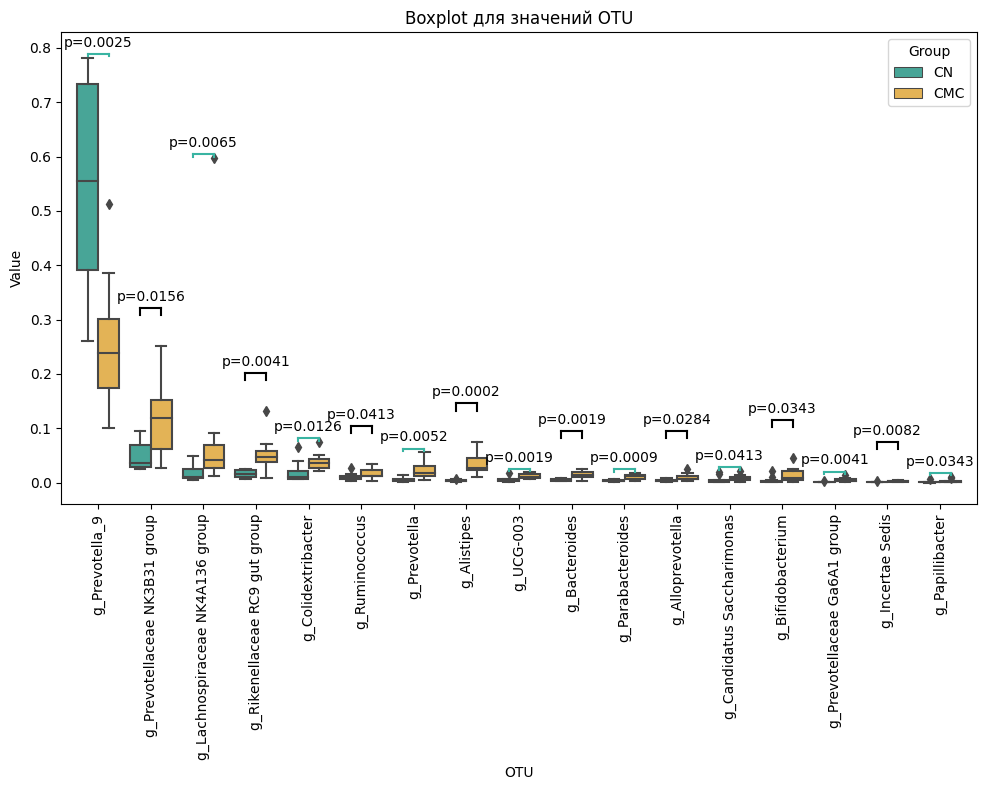

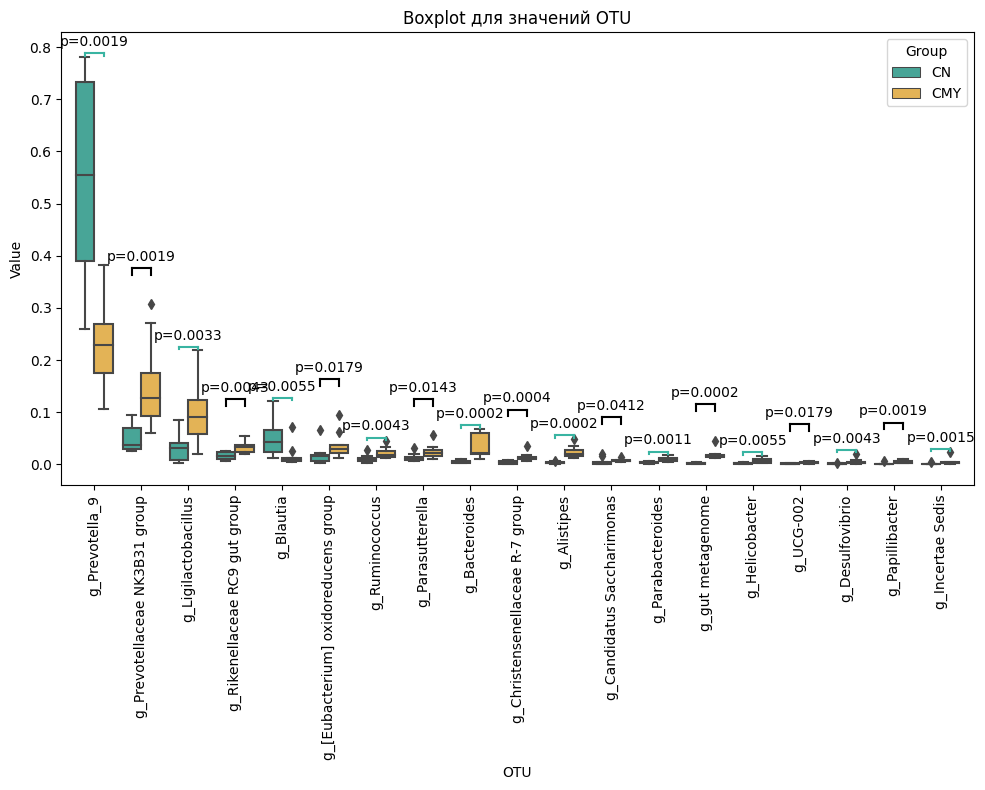

In [40]:
def relative_abundance_boxplot(df_dropped, transpose_df, df_group):
    # Преобразуем данные в длинный формат с помощью функции melt в pandas
    data_melt = df_dropped.melt(id_vars='Group', var_name='OTU', value_name='Value')

    my_palette = {'CN': '#39b4a2', 'CMC': '#faba3f', 'CMY': '#faba3f'} 

    # Фильтруем данные только для групп CN и CMC
    data_melt = data_melt[data_melt['Group'].isin(['CN', df_group])]

    # Создаем boxplot
    if df_group == "CMY":
        plt.figure(figsize=(10, 8))
    else:
        plt.figure(figsize=(10, 8))

    medians = data_melt.groupby('OTU')['Value'].median().sort_values(ascending=False)
    
    # Сортируем OTU в соответствии с их медианными значениями
    sorted_otus = medians.index.tolist()
    
    # Устанавливаем порядок для графика
    ax = sns.boxplot(data=data_melt, x='OTU', y='Value', hue='Group', order=sorted_otus, palette=my_palette)

    # Получаем значения p-value
    p_values = transpose_df.loc['Kruskal_pvalue'].to_dict()

    # Находим максимальное значение y для каждого OTU
    y_max_values = data_melt.groupby('OTU')['Value'].max()

    # Выводим значения p-value и линии для групп 'CN' и 'CMC'
    for i, otu in enumerate(sorted_otus):
        p_value = p_values.get(otu, np.nan)
        y_max = y_max_values[otu]
        if i % 2==0:
            height = 0.007
            ax.annotate(f'p={p_value:.4f}', xy=(i, y_max + height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=10, color = 'black')
        else:
            height = 0.07
            ax.annotate(f'p={p_value:.4f}', xy=(i, y_max + height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=10)
        
        # Добавляем вертикальные линии
        x1 = i - 0.2
        x2 = i + 0.2
        
        line_width = 1.5
        y_line = y_max + height  # Y-координата горизонтальной линии
        if i % 2==0:
            line_color = '#39b4a2'
            ax.plot([x1, x1], [y_max+.002, y_line], color=line_color, lw=line_width)
            ax.plot([x2, x2], [y_max+.002, y_line], color=line_color, lw=line_width)
            ax.plot([x1, x2], [y_line, y_line], color=line_color, lw=line_width)  # Горизонтальная линия
        else:
            line_color = 'black'
            ax.plot([x1, x1], [y_max+.057, y_line], color=line_color, lw=line_width)
            ax.plot([x2, x2], [y_max+.057, y_line], color=line_color, lw=line_width)
            ax.plot([x1, x2], [y_line, y_line], color=line_color, lw=line_width)  # Горизонтальная линия

    # Показываем график
    plt.title('Boxplot для значений OTU')
    plt.xticks(rotation=90)
    plt.tight_layout()
    if df_group == "CMY":
        plt.savefig('figures/realtive_ab/g_seaborn_boxplot_cmy.pdf', bbox_inches = 'tight')
    else:
        plt.savefig('figures/realtive_ab/g_seaborn_boxplot_cmc.pdf', bbox_inches = 'tight')
    plt.show()

# logarifm_cmc, log_cmc, minmax_cmc, z_norm_cmc merged_deleted_cmc_rel_dropped
# logarifm_cmy, log_cmy, minmax_cmy, z_norm_cmy merged_deleted_cmy_rel_dropped


relative_abundance_boxplot(merged_deleted_cmc_rel_dropped, kruskal_genus_cmc_transposed, 'CMC') #Логарифмическая нормализация
relative_abundance_boxplot(merged_deleted_cmy_rel_dropped, kruskal_genus_cmy_transposed, 'CMY') 

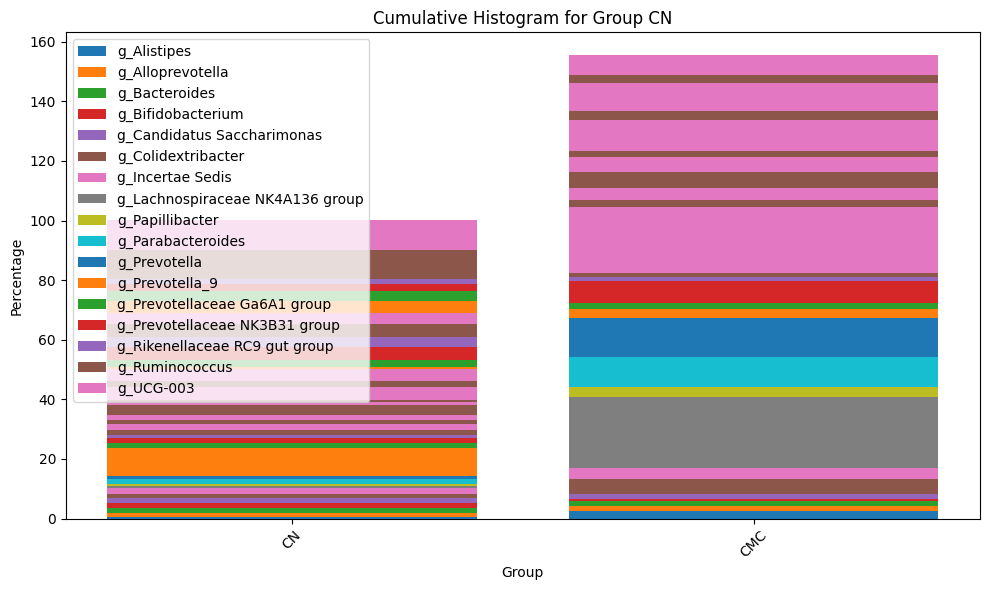

In [41]:
import matplotlib.pyplot as plt
import pandas as pd



# Создание DataFrame
df = merged_deleted_cmc_rel_dropped.copy()

# Преобразование процентных значений в значения, суммирующиеся до 100%
for column in df.columns[1:]:
    df[column] = df[column] / df[column].sum() * 100

# Построение гистограммы
plt.figure(figsize=(10, 6))
bottom = None
for column in df.columns[1:]:
    plt.bar(df["Group"], df[column], label=column, bottom=bottom)
    if bottom is None:
        bottom = df[column]
    else:
        bottom += df[column]

plt.xlabel("Group")
plt.ylabel("Percentage")
plt.title("Cumulative Histogram for Group CN")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()



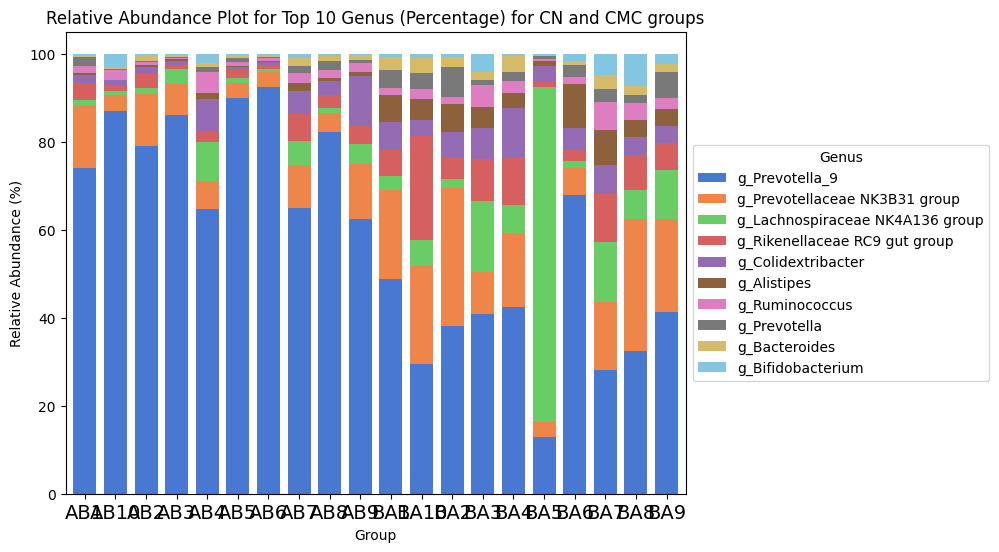

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from io import StringIO


df = merged_deleted_cmc_rel_dropped.copy()

# Rename the column for clarity
df = df.rename(columns={"merged_deleted_cmc_rel_dropped": "Group"})

# Filter data for only CN and CMC groups
df_filtered = df[df["Group"].isin(["CN", "CMC"])]

# Transform the data for visualization
data = df_filtered.drop(columns=["Group"]).reset_index()
data = data.melt(id_vars=["index"], var_name="Genus", value_name="Relative Abundance")
pivot_data = data.pivot_table(index="index", columns="Genus", values="Relative Abundance", fill_value=0)

top_10_genus = pivot_data.sum(axis=0).nlargest(10).index
top_10_data = pivot_data[top_10_genus]

normalized_data = top_10_data.div(top_10_data.sum(axis=1), axis=0) * 100
palette = sns.color_palette("muted", n_colors=10)

# 4. Визуализация
fig, ax = plt.subplots(figsize=(10, 6))
normalized_data.plot(kind="bar", stacked=True, color=palette, ax=ax, width=0.75)

plt.title("Relative Abundance Plot for Top 10 Genus (Percentage) for CN and CMC groups")
plt.xlabel("Group")
plt.ylabel("Relative Abundance (%)")
plt.xticks(rotation=0, fontsize=14)

# Создание легенды вне графика
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title="Genus", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()


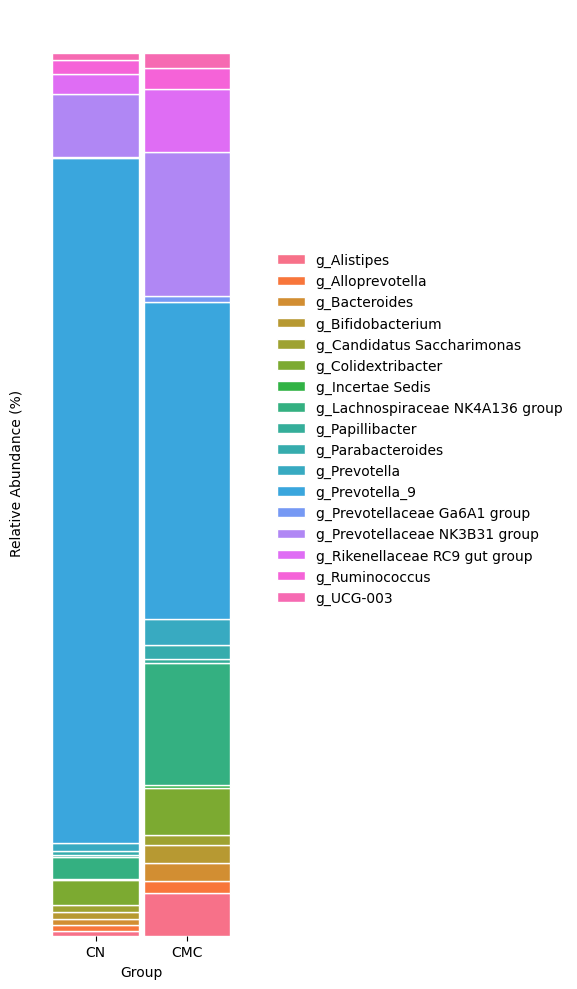

In [43]:
import pandas as pd
from io import StringIO

df = merged_deleted_cmc_rel_dropped.copy()

# Расчет средних значений для каждой группы (CN и CMC)
CN_mean = df[df['Group'] == 'CN'].mean(numeric_only=True)
CMC_mean = df[df['Group'] == 'CMC'].mean(numeric_only=True)

# Добавление средних значений в исходный DataFrame
df = pd.concat([df, pd.DataFrame([CN_mean], index=['CN_mean']), pd.DataFrame([CMC_mean], index=['CMC_mean'])])

# Расчет суммы средних значений для каждой группы
CN_sum = CN_mean.sum()
CMC_sum = CMC_mean.sum()

# Расчет относительного изобилия для каждой бактерии в каждой группе
rel_CN_mean = (CN_mean * 100) / CN_sum
rel_CMC_mean = (CMC_mean * 100) / CMC_sum

rel_CN_mean['Group'] = 'Rel_CN_mean'
rel_CMC_mean['Group'] = 'Rel_CMC_mean'

df = pd.concat([df, pd.DataFrame([rel_CN_mean], index=['Rel_CN_mean']), pd.DataFrame([rel_CMC_mean], index=['Rel_CMC_mean'])])

colors = sns.color_palette("husl", n_colors=17)

# Выберите только строки Rel_CN_mean и Rel_CMC_mean и удалите столбец 'Group'
rel_data = df.loc[['Rel_CN_mean', 'Rel_CMC_mean']].drop(columns='Group')

# Построение накопительной столбчатой диаграммы
fig, ax = plt.subplots(figsize=(6, 10))
rel_data.plot(kind='bar', stacked=True, ax=ax, width=0.95, color=colors, edgecolor="white")  # установите width=0.95

# Убираем фон и границы
ax.set_facecolor('none')  # Убираем фон осей
fig.set_facecolor('none')  # Убираем фон фигуры
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("")
plt.xlabel("Group")
plt.ylabel("Relative Abundance (%)")
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([0, 1])
ax.set_xticklabels(['CN', 'CMC'])
plt.xticks(rotation=0, fontsize=10)

plt.legend(title="", bbox_to_anchor=(1.05, 0.75), loc='upper left', frameon = False)
plt.savefig('figures/realtive_ab/diagramma_CMC.pdf', bbox_inches = "tight")
plt.tight_layout()
plt.show()


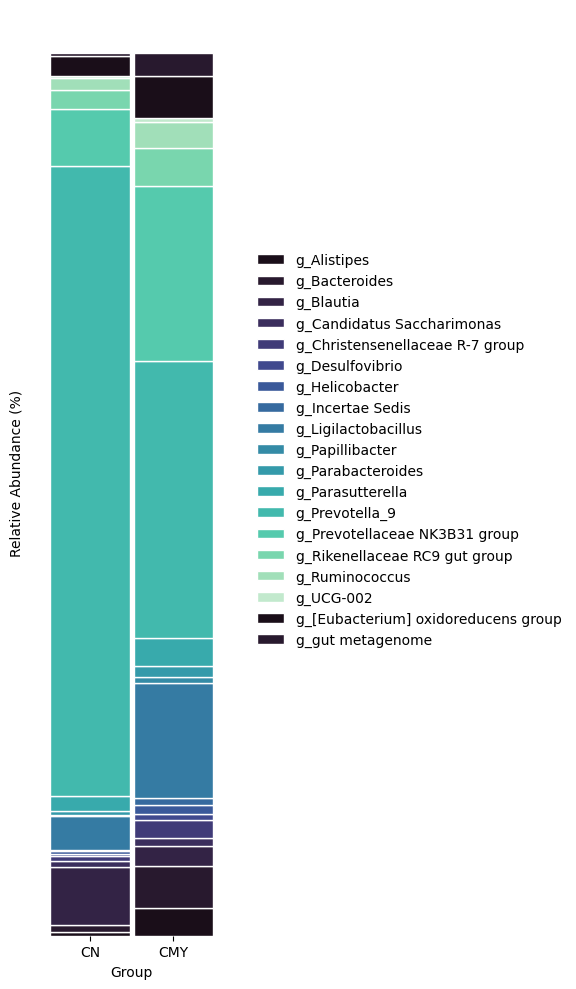

In [44]:
import pandas as pd
from io import StringIO

df = merged_deleted_cmy_rel_dropped.copy()

# Расчет средних значений для каждой группы (CN и CMC)
CN_mean = df[df['Group'] == 'CN'].mean(numeric_only=True)
CMC_mean = df[df['Group'] == 'CMY'].mean(numeric_only=True)

# Добавление средних значений в исходный DataFrame
df = pd.concat([df, pd.DataFrame([CN_mean], index=['CN_mean']), pd.DataFrame([CMC_mean], index=['CMY_mean'])])

# Расчет суммы средних значений для каждой группы
CN_sum = CN_mean.sum()
CMC_sum = CMC_mean.sum()

# Расчет относительного изобилия для каждой бактерии в каждой группе
rel_CN_mean = (CN_mean * 100) / CN_sum
rel_CMC_mean = (CMC_mean * 100) / CMC_sum

rel_CN_mean['Group'] = 'Rel_CN_mean'
rel_CMC_mean['Group'] = 'Rel_CMY_mean'

df = pd.concat([df, pd.DataFrame([rel_CN_mean], index=['Rel_CN_mean']), pd.DataFrame([rel_CMC_mean], index=['Rel_CMY_mean'])])

colors = sns.color_palette("mako", n_colors=17)

# Выберите только строки Rel_CN_mean и Rel_CMC_mean и удалите столбец 'Group'
rel_data = df.loc[['Rel_CN_mean', 'Rel_CMY_mean']].drop(columns='Group')

# Построение накопительной столбчатой диаграммы
fig, ax = plt.subplots(figsize=(6, 10))
rel_data.plot(kind='bar', stacked=True, ax=ax, width=0.95, color=colors, edgecolor="white")  # установите width=0.95

# Убираем фон и границы
ax.set_facecolor('none')  # Убираем фон осей
fig.set_facecolor('none')  # Убираем фон фигуры
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("")
plt.xlabel("Group")
plt.ylabel("Relative Abundance (%)")
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([0, 1])
ax.set_xticklabels(['CN', 'CMY'])
plt.xticks(rotation=0, fontsize=10)

plt.legend(title="", bbox_to_anchor=(1.05, 0.75), loc='upper left', frameon = False)
plt.savefig('figures/realtive_ab/diagramma_CMY.pdf', bbox_inches = "tight")
plt.tight_layout()
plt.show()


In [45]:
all_pathways = pd.read_csv('dataframes/output_data/pathway/pathwat_done.csv',  sep='\t')
#all_pathways = pd.read_csv('delete.csv', sep=',')
all_pathways

,pathway,description,#SampleID,Abundance,Group,relative_abundance
0,1CMET2-PWY,N10-formyl-tetrahydrofolate biosynthesis,AB1,56985.915525,CN,6.932489e-03
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,4-hydroxyphenylacetate degradation,AB1,14.062229,CN,1.710708e-06
2,AEROBACTINSYN-PWY,aerobactin biosynthesis,AB1,0.000000,CN,0.000000e+00
3,ALL-CHORISMATE-PWY,superpathway of chorismate metabolism,AB1,497.560257,CN,6.052954e-05
4,ANAEROFRUCAT-PWY,homolactic fermentation,AB1,62225.308477,CN,7.569876e-03
...,...,...,...,...,...,...
11798,TYRFUMCAT-PWY,L-tyrosine degradation I,BA9,1912.219795,CMC,1.881668e-04
11799,UBISYN-PWY,superpathway of ubiquinol-8 biosynthesis (prok...,BA9,1836.745445,CMC,1.807399e-04
11800,UDPNAGSYN-PWY,UDP-N-acetyl-D-glucosamine biosynthesis I,BA9,42170.145429,CMC,4.149638e-03
11801,VALDEG-PWY,L-valine degradation I,BA9,5.980163,CMC,5.884617e-07


In [46]:
pathway_data_cmc = pd.read_csv('dataframes/output_data/pathway/final_pathway_cmc.csv', sep = '\t')
pathway_data_cmy = pd.read_csv('dataframes/output_data/pathway/final_pathway_cmy.csv', sep = '\t')
pathway_data_cmy

,description,CMY,CN,p_value,diff
0,"1,4-dihydroxy-6-naphthoate biosynthesis I",0.000239,0.000112,3.429855e-05,-0.000127
1,8-amino-7-oxononanoate biosynthesis I,0.002927,0.002264,1.159651e-04,-0.000663
2,L-methionine biosynthesis III,0.001754,0.001052,9.820888e-05,-0.000701
3,L-tryptophan degradation to 2-amino-3-carboxym...,0.000041,0.000002,1.972888e-06,-0.000039
4,NAD biosynthesis II (from tryptophan),0.000065,0.000003,1.881388e-06,-0.000062
5,TCA cycle VIII (helicobacter),0.002508,0.001314,6.690892e-05,-0.001194
6,biotin biosynthesis I,0.002918,0.002127,3.640984e-06,-0.000791
7,biotin biosynthesis II,0.000098,0.000023,5.915552e-05,-0.000075
8,chondroitin sulfate degradation I (bacterial),0.000198,0.000082,1.146332e-04,-0.000116
9,fatty acid &beta;-oxidation I,0.000689,0.000285,8.634235e-05,-0.000404


In [47]:
keep_rows_cmc = pathway_data_cmc['description'].tolist()
keep_rows_cmy = pathway_data_cmy['description'].tolist()
# Фильтрация данных по указанным строкам
pathway_meta_filtered_cmc = all_pathways[all_pathways["description"].isin(keep_rows_cmc)].drop(columns=['pathway', 'Abundance']).rename(columns={'#SampleID':'SampleID'})
pathway_meta_filtered_cmy = all_pathways[all_pathways["description"].isin(keep_rows_cmy)].drop(columns=['pathway', 'Abundance']).rename(columns={'#SampleID':'SampleID'})

pathway_meta_filtered_cmc = pathway_meta_filtered_cmc[~pathway_meta_filtered_cmc['Group'].isin(['CMY'])]
pathway_meta_filtered_cmy = pathway_meta_filtered_cmy[~pathway_meta_filtered_cmy['Group'].isin(['CMC'])]
#pathway_meta_filtered_cmc = pathway_meta_filtered[pathway_meta_filtered['SampleID']!='BB10']

pathway_meta_filtered_cmc.to_csv('dataframes/output_data/data_check/pathway_meta_filtered_cmc.csv', sep=',')
pathway_meta_filtered_cmy.to_csv('dataframes/output_data/data_check/pathway_meta_filtered_cmy.csv', sep=',')

In [48]:
merged_deleted_cmc_rel_dropped

,Group,g_Alistipes,g_Alloprevotella,g_Bacteroides,g_Bifidobacterium,g_Candidatus Saccharimonas,g_Colidextribacter,g_Incertae Sedis,g_Lachnospiraceae NK4A136 group,g_Papillibacter,g_Parabacteroides,g_Prevotella,g_Prevotella_9,g_Prevotellaceae Ga6A1 group,g_Prevotellaceae NK3B31 group,g_Rikenellaceae RC9 gut group,g_Ruminococcus,g_UCG-003
AB1,CN,0.001712,0.009596,0.003231,0.001664,0.002859,0.012973,0.000711,0.009402,0.000695,0.004006,0.013942,0.496511,0.000598,0.094265,0.024976,0.011244,0.005525
AB10,CN,0.001585,0.002059,0.003306,0.021411,0.001160,0.007025,0.000699,0.006301,0.000399,0.002832,0.001909,0.628228,0.000699,0.026003,0.009882,0.015684,0.002271
AB2,CN,0.003510,0.003777,0.009564,0.002861,0.005278,0.009691,0.000992,0.010327,0.001450,0.004362,0.002213,0.611553,0.001017,0.091402,0.025830,0.005939,0.002340
AB3,CN,0.003060,0.002699,0.003101,0.003575,0.001041,0.008963,0.000948,0.031217,0.000577,0.001710,0.001607,0.776199,0.000474,0.062732,0.007407,0.003462,0.002864
AB4,CN,0.007377,0.004122,0.005251,0.010987,0.020478,0.040142,0.003977,0.049278,0.006642,0.003649,0.005999,0.353439,0.002127,0.034602,0.012575,0.026844,0.018181
AB5,CN,0.003029,0.003425,0.005903,0.001685,0.001388,0.006487,0.000969,0.010242,0.000341,0.001608,0.007940,0.781952,0.002588,0.030044,0.014846,0.007775,0.001839
AB6,CN,0.002072,0.002377,0.003628,0.002629,0.002850,0.006763,0.000684,0.005227,0.000410,0.002398,0.002461,0.769252,0.001010,0.028533,0.007004,0.004217,0.003418
AB7,CN,0.006687,0.005870,0.006706,0.004089,0.003216,0.021280,0.001236,0.022097,0.000890,0.006851,0.006669,0.259790,0.001272,0.038925,0.024423,0.009522,0.007069
AB8,CN,0.003346,0.006117,0.006873,0.002744,0.000728,0.019597,0.000672,0.007307,0.000616,0.005277,0.011842,0.479059,0.000630,0.025743,0.016210,0.010779,0.006635
AB9,CN,0.004369,0.005904,0.006221,0.001994,0.016746,0.066431,0.001520,0.026592,0.001330,0.004511,0.004353,0.361186,0.001361,0.072620,0.023188,0.011903,0.006822


In [49]:
def merged_data_preparation(df):
    merged_deleted_cmc_rel_dropped_kendall = df.copy()
    merged_deleted_cmc_rel_dropped_kendall = merged_deleted_cmc_rel_dropped_kendall.reset_index()
    return merged_deleted_cmc_rel_dropped_kendall.rename(columns = {'index':'SampleID'})
    #merged_deleted_cmc_rel_dropped_kendall = merged_deleted_cmc_rel_dropped_kendall[merged_deleted_cmc_rel_dropped_kendall['SampleID']!='BA10']
    #merged_deleted_cmc_rel_dropped_kendall = merged_deleted_cmc_rel_dropped_kendall[merged_deleted_cmc_rel_dropped_kendall['SampleID']!='AB10']
merged_deleted_cmc_rel_dropped_kendall = merged_data_preparation(merged_deleted_cmc_rel_dropped)
merged_deleted_cmy_rel_dropped_kendall = merged_data_preparation(merged_deleted_cmy_rel_dropped)
merged_deleted_cmy_rel_dropped_kendall

,SampleID,Group,g_Alistipes,g_Bacteroides,g_Blautia,g_Candidatus Saccharimonas,g_Christensenellaceae R-7 group,g_Desulfovibrio,g_Helicobacter,g_Incertae Sedis,...,g_Papillibacter,g_Parabacteroides,g_Parasutterella,g_Prevotella_9,g_Prevotellaceae NK3B31 group,g_Rikenellaceae RC9 gut group,g_Ruminococcus,g_UCG-002,g_[Eubacterium] oxidoreducens group,g_gut metagenome
0,AB1,CN,0.001712,0.003231,0.066252,0.002859,0.004410,0.001777,0.003441,0.000711,...,0.000695,0.004006,0.014362,0.496511,0.094265,0.024976,0.011244,0.000485,0.015735,0.002052
1,AB10,CN,0.001585,0.003306,0.050994,0.001160,0.006239,0.000811,0.001086,0.000699,...,0.000399,0.002832,0.020375,0.628228,0.026003,0.009882,0.015684,0.000287,0.014948,0.003082
2,AB2,CN,0.003510,0.009564,0.030535,0.005278,0.001908,0.000445,0.003421,0.000992,...,0.001450,0.004362,0.031845,0.611553,0.091402,0.025830,0.005939,0.000471,0.005087,0.001094
3,AB3,CN,0.003060,0.003101,0.012806,0.001041,0.001164,0.000979,0.001226,0.000948,...,0.000577,0.001710,0.007820,0.776199,0.062732,0.007407,0.003462,0.000598,0.003235,0.001669
4,AB4,CN,0.007377,0.005251,0.094408,0.020478,0.007863,0.002442,0.004923,0.003977,...,0.006642,0.003649,0.010488,0.353439,0.034602,0.012575,0.026844,0.003492,0.066146,0.003623
5,AB5,CN,0.003029,0.005903,0.020462,0.001388,0.001255,0.000782,0.001982,0.000969,...,0.000341,0.001608,0.005793,0.781952,0.030044,0.014846,0.007775,0.000297,0.003965,0.001817
6,AB6,CN,0.002072,0.003628,0.012463,0.002850,0.001588,0.000883,0.000978,0.000684,...,0.000410,0.002398,0.006994,0.769252,0.028533,0.007004,0.004217,0.000726,0.021581,0.001693
7,AB7,CN,0.006687,0.006706,0.034564,0.003216,0.008214,0.001835,0.003725,0.001236,...,0.000890,0.006851,0.012466,0.259790,0.038925,0.024423,0.009522,0.002362,0.019808,0.002617
8,AB8,CN,0.003346,0.006873,0.120902,0.000728,0.006411,0.000784,0.002604,0.000672,...,0.000616,0.005277,0.007587,0.479059,0.025743,0.016210,0.010779,0.002506,0.012066,0.000910
9,AB9,CN,0.004369,0.006221,0.067017,0.016746,0.005144,0.003656,0.001836,0.001520,...,0.001330,0.004511,0.012140,0.361186,0.072620,0.023188,0.011903,0.002738,0.016430,0.003720


/tmp/ipykernel_8978/4294095084.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_8978/4294095084.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


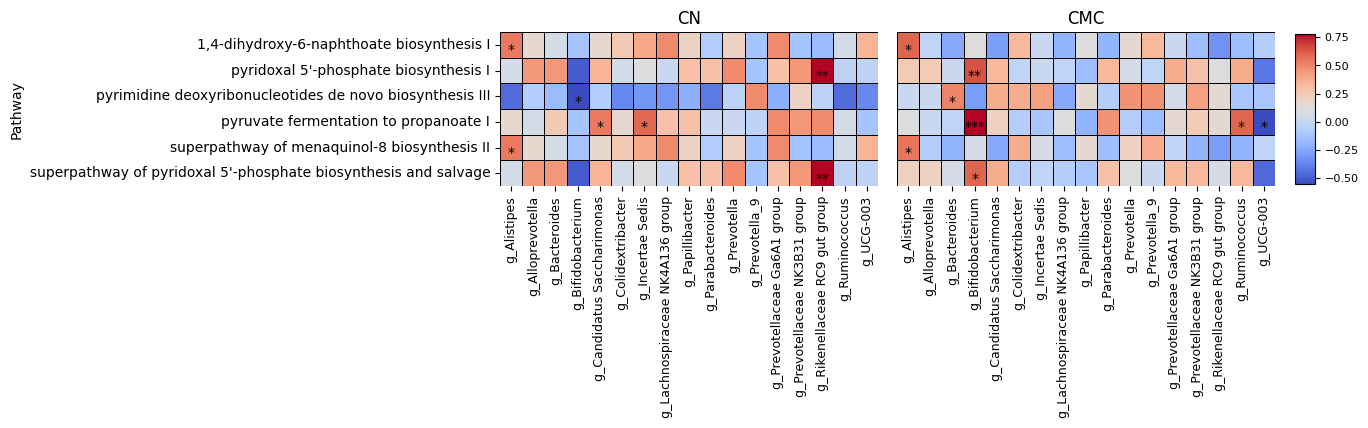

In [62]:
from scipy.stats import kendalltau
# Преобразуем pathway_meta_filtered_cmc так, чтобы он стал "шире"
pathway_pivot = pathway_meta_filtered_cmc.pivot(index='SampleID', columns='description', values='relative_abundance')

# Заменяем пропущенные значения нулями
pathway_pivot.fillna(0, inplace=True)

# Добавляем информацию о группах
group_info = pathway_meta_filtered_cmc[['SampleID', 'Group']].drop_duplicates()
pathway_pivot = pathway_pivot.merge(group_info, on='SampleID')

# Вычисляем корреляции для каждой группы
results = []
pathway_pivot
for group in pathway_pivot.Group.unique():
    otu_sub = merged_deleted_cmc_rel_dropped_kendall[merged_deleted_cmc_rel_dropped_kendall.Group == group].drop(columns='Group').set_index('SampleID')
    pathway_sub = pathway_pivot[pathway_pivot.Group == group].drop(columns='Group').set_index('SampleID')
    
    for otu_col in otu_sub.columns:
        for pathway_col in pathway_sub.columns:
            corr, pval = kendalltau(otu_sub[otu_col], pathway_sub[pathway_col])
            results.append({'Group': group, 'OTU': otu_col, 'Pathway': pathway_col, 'Correlation': corr, 'P-value': pval})
            
results_df = pd.DataFrame(results)

# # Создаем датафреймы для каждой группы
groups = results_df.Group.unique()
group_dfs = [results_df[results_df.Group == group].pivot(index='Pathway', columns='OTU', values='Correlation') for group in groups]
# создаем отдельные датафреймы для каждой группы и отдельные для значений p
group_dfs = []
group_dfs_p = []
for group in groups:
    group_df = results_df[results_df.Group == group].pivot(index='Pathway', columns='OTU', values='Correlation')
    group_df_p = results_df[results_df.Group == group].pivot(index='Pathway', columns='OTU', values='P-value')
    group_dfs.append(group_df)
    group_dfs_p.append(group_df_p)

# рисуем тепловые карты
#fig, axes = plt.subplots(1, len(groups), figsize=(10, 5), gridspec_kw={'width_ratios': [1 for _ in range(len(groups))]})
fig, axes = plt.subplots(1, len(groups), figsize=(10, 2), gridspec_kw={'width_ratios': [1 for _ in range(len(groups))]})
for i, (group_df, group_df_p) in enumerate(zip(group_dfs, group_dfs_p)):
    heatmap = sns.heatmap(group_df, ax=axes[i], cmap='coolwarm', annot=False, cbar=False, square=False, linewidths=0.4, linecolor='black')
    heatmap.tick_params(axis='x', which='major', labelsize=9)
    axes[i].set_title(groups[i]) # добавляем название группы в заголовок каждой подграфики
    axes[i].set_xlabel('')
    if i > 0:
        axes[i].set_yticklabels([])
        axes[i].set_yticks([]) # удаляем черточки на оси y
        axes[i].set_ylabel('')
    # добавляем звезды в ячейки с p <= 0.05, p <= 0.01, p <= 0.001
    for j, row in enumerate(group_df_p.values):
        for k, text in enumerate(row):
            if text <= 0.001:
                axes[i].text(k+0.5, j+0.7, '***', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            color='black', fontsize=10)
            elif text <= 0.01:
                axes[i].text(k+0.5, j+0.7, '**', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            color='black', fontsize=10)
            elif text <= 0.05:
                axes[i].text(k+0.5, j+0.7, '*', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            color='black', fontsize=10)

cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.75])
cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cbar_ax) 
cbar.ax.tick_params(labelsize=8)

results_df.to_csv('dataframes/output_data/kendall/kendall_cmc.csv', sep = '\t')

#plt.suptitle("Kendall correlation heatmap", fontsize=12, fontweight='bold', x = 0.6, y = 0.6)
plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.savefig('figures/kendall/kendallCorr2_CMC.pdf', bbox_inches = "tight")
plt.show()



/tmp/ipykernel_8978/3782108792.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


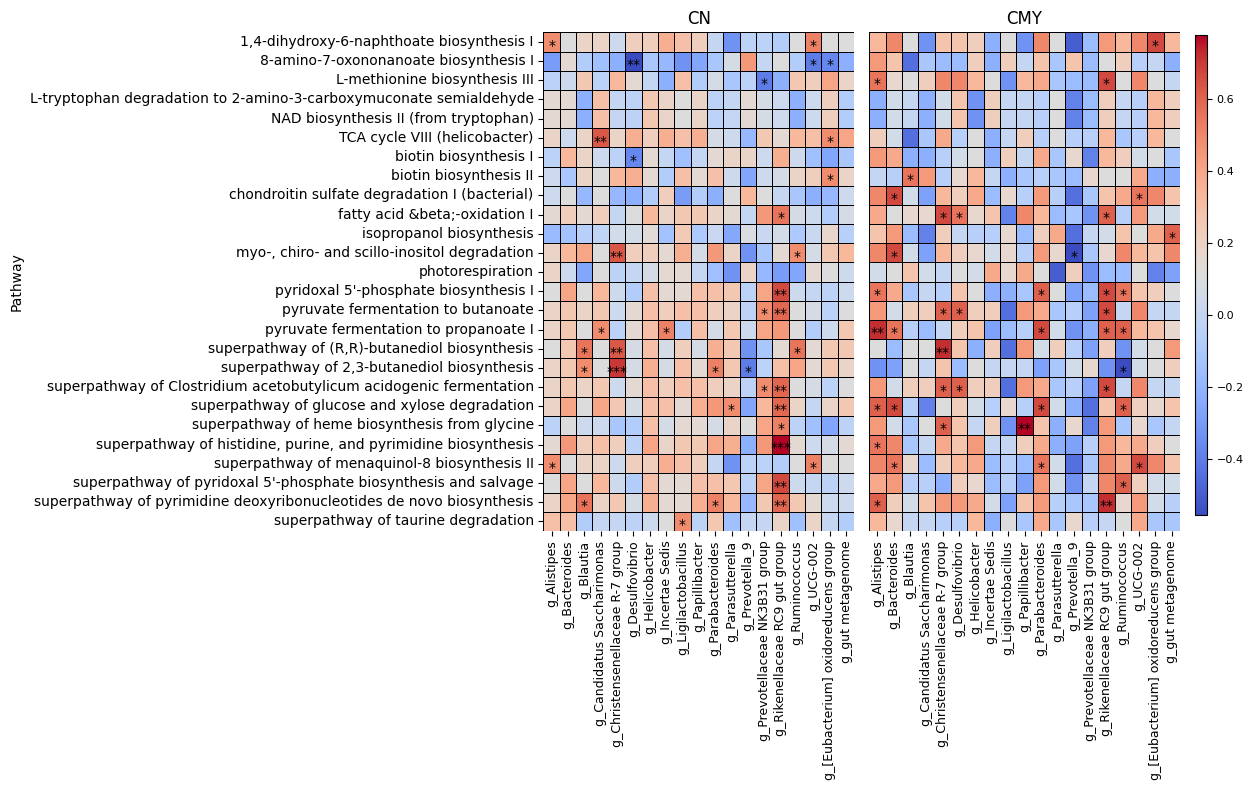

In [51]:
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Преобразуем pathway_meta_filtered_cmy так, чтобы он стал "шире"
pathway_pivot = pathway_meta_filtered_cmy.pivot(index='SampleID', columns='description', values='relative_abundance')

# Заменяем пропущенные значения нулями
pathway_pivot.fillna(0, inplace=True)

# Добавляем информацию о группах
group_info = pathway_meta_filtered_cmy[['SampleID', 'Group']].drop_duplicates()
pathway_pivot = pathway_pivot.merge(group_info, on='SampleID')

# Вычисляем корреляции для каждой группы
results = []
pathway_pivot
for group in pathway_pivot.Group.unique():
    otu_sub = merged_deleted_cmy_rel_dropped_kendall[merged_deleted_cmy_rel_dropped_kendall.Group == group].drop(columns='Group').set_index('SampleID')
    pathway_sub = pathway_pivot[pathway_pivot.Group == group].drop(columns='Group').set_index('SampleID')
    
    for otu_col in otu_sub.columns:
        for pathway_col in pathway_sub.columns:
            corr, pval = kendalltau(otu_sub[otu_col], pathway_sub[pathway_col])
            results.append({'Group': group, 'OTU': otu_col, 'Pathway': pathway_col, 'Correlation': corr, 'P-value': pval})
            
results_df = pd.DataFrame(results)

# # Создаем датафреймы для каждой группы
groups = results_df.Group.unique()
group_dfs = [results_df[results_df.Group == group].pivot(index='Pathway', columns='OTU', values='Correlation') for group in groups]
# создаем отдельные датафреймы для каждой группы и отдельные для значений p
group_dfs = []
group_dfs_p = []
for group in groups:
    group_df = results_df[results_df.Group == group].pivot(index='Pathway', columns='OTU', values='Correlation')
    group_df_p = results_df[results_df.Group == group].pivot(index='Pathway', columns='OTU', values='P-value')
    group_dfs.append(group_df)
    group_dfs_p.append(group_df_p)

# рисуем тепловые карты
#fig, axes = plt.subplots(1, len(groups), figsize=(10, 5), gridspec_kw={'width_ratios': [1 for _ in range(len(groups))]})
fig, axes = plt.subplots(1, len(groups), figsize=(12, 8), gridspec_kw={'width_ratios': [1 for _ in range(len(groups))]})
for i, (group_df, group_df_p) in enumerate(zip(group_dfs, group_dfs_p)):
    heatmap = sns.heatmap(group_df, ax=axes[i], cmap='coolwarm', annot=False, cbar=False, square=False, linewidths=0.4, linecolor='black')
    heatmap.tick_params(axis='x', which='major', labelsize=9)
    axes[i].set_title(groups[i]) # добавляем название группы в заголовок каждой подграфики
    axes[i].set_xlabel('')
    if i > 0:
        axes[i].set_yticklabels([])
        axes[i].set_yticks([]) # удаляем черточки на оси y
        axes[i].set_ylabel('')
    # добавляем звезды в ячейки с p <= 0.05, p <= 0.01, p <= 0.001
    for j, row in enumerate(group_df_p.values):
        for k, text in enumerate(row):
            if text <= 0.001:
                axes[i].text(k+0.5, j+0.7, '***', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            color='black', fontsize=10)
            elif text <= 0.01:
                axes[i].text(k+0.5, j+0.7, '**', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            color='black', fontsize=10)
            elif text <= 0.05:
                axes[i].text(k+0.5, j+0.7, '*', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            color='black', fontsize=10)

cbar_ax = fig.add_axes([1, 0.35, 0.01, 0.6])
cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cbar_ax) 
cbar.ax.tick_params(labelsize=8)

#plt.suptitle("Kendall correlation heatmap", fontsize=12, fontweight='bold', x = 0.6, y = 0.6)

plt.tight_layout()
plt.savefig('figures/kendall/kendallCorr2_CMY.pdf', bbox_inches = "tight")
plt.show()



In [52]:
merged_deleted_cmc_rel_dropped
merged_deleted_cmy_rel_dropped

,Group,g_Alistipes,g_Bacteroides,g_Blautia,g_Candidatus Saccharimonas,g_Christensenellaceae R-7 group,g_Desulfovibrio,g_Helicobacter,g_Incertae Sedis,g_Ligilactobacillus,g_Papillibacter,g_Parabacteroides,g_Parasutterella,g_Prevotella_9,g_Prevotellaceae NK3B31 group,g_Rikenellaceae RC9 gut group,g_Ruminococcus,g_UCG-002,g_[Eubacterium] oxidoreducens group,g_gut metagenome
AB1,CN,0.001712,0.003231,0.066252,0.002859,0.004410,0.001777,0.003441,0.000711,0.030355,0.000695,0.004006,0.014362,0.496511,0.094265,0.024976,0.011244,0.000485,0.015735,0.002052
AB10,CN,0.001585,0.003306,0.050994,0.001160,0.006239,0.000811,0.001086,0.000699,0.003169,0.000399,0.002832,0.020375,0.628228,0.026003,0.009882,0.015684,0.000287,0.014948,0.003082
AB2,CN,0.003510,0.009564,0.030535,0.005278,0.001908,0.000445,0.003421,0.000992,0.006982,0.001450,0.004362,0.031845,0.611553,0.091402,0.025830,0.005939,0.000471,0.005087,0.001094
AB3,CN,0.003060,0.003101,0.012806,0.001041,0.001164,0.000979,0.001226,0.000948,0.006037,0.000577,0.001710,0.007820,0.776199,0.062732,0.007407,0.003462,0.000598,0.003235,0.001669
AB4,CN,0.007377,0.005251,0.094408,0.020478,0.007863,0.002442,0.004923,0.003977,0.031111,0.006642,0.003649,0.010488,0.353439,0.034602,0.012575,0.026844,0.003492,0.066146,0.003623
AB5,CN,0.003029,0.005903,0.020462,0.001388,0.001255,0.000782,0.001982,0.000969,0.010705,0.000341,0.001608,0.005793,0.781952,0.030044,0.014846,0.007775,0.000297,0.003965,0.001817
AB6,CN,0.002072,0.003628,0.012463,0.002850,0.001588,0.000883,0.000978,0.000684,0.031594,0.000410,0.002398,0.006994,0.769252,0.028533,0.007004,0.004217,0.000726,0.021581,0.001693
AB7,CN,0.006687,0.006706,0.034564,0.003216,0.008214,0.001835,0.003725,0.001236,0.084628,0.000890,0.006851,0.012466,0.259790,0.038925,0.024423,0.009522,0.002362,0.019808,0.002617
AB8,CN,0.003346,0.006873,0.120902,0.000728,0.006411,0.000784,0.002604,0.000672,0.044248,0.000616,0.005277,0.007587,0.479059,0.025743,0.016210,0.010779,0.002506,0.012066,0.000910
AB9,CN,0.004369,0.006221,0.067017,0.016746,0.005144,0.003656,0.001836,0.001520,0.044462,0.001330,0.004511,0.012140,0.361186,0.072620,0.023188,0.011903,0.002738,0.016430,0.003720


In [53]:
from scipy.stats import ttest_ind

def kruskal_p_value(df, grp):
    #df_copy = merged_deleted_cmc.copy()
    #df_copy = box_rel_cmc.copy()
    df_copy = df.copy()

    # Разделение DataFrame на две группы
    group_cmc = df_copy[df_copy['Group'] == grp]
    group_cn = df_copy[df_copy['Group'] == 'CN']

    # Создание пустой DataFrame для хранения результатов
    p_values = pd.DataFrame(index=['p-value'], columns=df_copy.columns[1:])

    # Проведите t-тест для каждого столбца и сохраните p-value
    for column in df_copy.columns[1:]:
        t_stat, p_val = ttest_ind(group_cmc[column], group_cn[column], equal_var=False, nan_policy='omit') # t-test Стьюдента
        p_values[column] = p_val

    # Транспонирование DataFrame и переименование столбцов
    p_values = p_values.transpose().reset_index()
    p_values.columns = ['OTU', f'CN_vs_{grp}_p_value']

    # Рассчет средних значений для каждой группы и добавьте их в DataFrame
    p_values['CN'] = group_cn.mean(numeric_only=True).values
    p_values[grp] = group_cmc.mean(numeric_only=True).values

    # Изменение порядка столбцов
    p_values = p_values[['OTU', 'CN', grp, f'CN_vs_{grp}_p_value']]

    return p_values.loc[(p_values[f'CN_vs_{grp}_p_value'] <= 0.05)]

less_zero_five_cmc = kruskal_p_value(merged_deleted_cmc_rel_dropped, 'CMC')
less_zero_five_cmy = kruskal_p_value(merged_deleted_cmy_rel_dropped, 'CMY')
print(f'CMY dataframe (P-value <= 0.05): {less_zero_five_cmy.shape}')
print(f'CMC dataframe (P-value <= 0.05): {less_zero_five_cmc.shape}')
less_zero_five_cmy

CMY dataframe (P-value <= 0.05): (15, 4)
CMC dataframe (P-value <= 0.05): (12, 4)


,OTU,CN,CMY,CN_vs_CMY_p_value
0,g_Alistipes,0.003675,0.023461,0.001094
1,g_Bacteroides,0.005378,0.036955,0.003539
2,g_Blautia,0.051040,0.016443,0.022411
4,g_Christensenellaceae R-7 group,0.004420,0.014999,0.004584
6,g_Helicobacter,0.002522,0.008293,0.009214
8,g_Ligilactobacillus,0.029329,0.098991,0.007901
9,g_Papillibacter,0.001335,0.004878,0.008186
10,g_Parabacteroides,0.003721,0.009554,0.003868
11,g_Parasutterella,0.012987,0.024579,0.044986
12,g_Prevotella_9,0.551717,0.238025,0.000451


In [54]:
def transpose_df(df):    
    less_zero_five_transposed = df.T
    less_zero_five_transposed.columns = less_zero_five_transposed.iloc[0]
    return less_zero_five_transposed[1:]
less_zero_five_transposed_cmc = transpose_df(less_zero_five_cmc)
less_zero_five_transposed_cmy = transpose_df(less_zero_five_cmy)


In [55]:
def preparing_data(started_df, transposed_df):
    # Сначала получим список всех OTU в merged_deleted_cmc_rel
    all_otus_in_merged = started_df.columns.to_list()

    # Затем получим список всех OTU в less_zero_five_transposed
    otus_in_less_zero_five_transposed = transposed_df.columns.to_list()

    # Определим, какие OTU присутствуют в merged_deleted_cmc_rel, но отсутствуют в less_zero_five_transposed
    otus_to_drop = [otu for otu in all_otus_in_merged if otu not in otus_in_less_zero_five_transposed and otu != 'Group']

    # Теперь удалим эти столбцы из merged_deleted_cmc_rel
    return started_df.drop(columns=otus_to_drop)

merged_deleted_cmc_rel_dropped = preparing_data(merged_deleted_cmc_rel_dropped, less_zero_five_transposed_cmc)
merged_deleted_cmy_rel_dropped = preparing_data(merged_deleted_cmy_rel_dropped, less_zero_five_transposed_cmy)

In [56]:
from skbio.diversity import alpha_diversity


def alpha_diversity_calculating(df_deleted_rel_dropped):
    df_rel = df_deleted_rel_dropped.copy()
    data_without_group = df_rel.drop(columns=['Group'])
    data_without_group[data_without_group <= 0] = 1e-10
    shannon_diversity = alpha_diversity('shannon', data_without_group)
    simpson_diversity = alpha_diversity('simpson', data_without_group)

    shannon_diversity.index = df_rel.index
    simpson_diversity.index = df_rel.index

    df_rel['Shannon'] = shannon_diversity
    df_rel['Simpson'] = simpson_diversity

    return df_rel
alpha_cmc_g = alpha_diversity_calculating(merged_deleted_cmc_rel_dropped)
alpha_cmy_g = alpha_diversity_calculating(merged_deleted_cmy_rel_dropped)

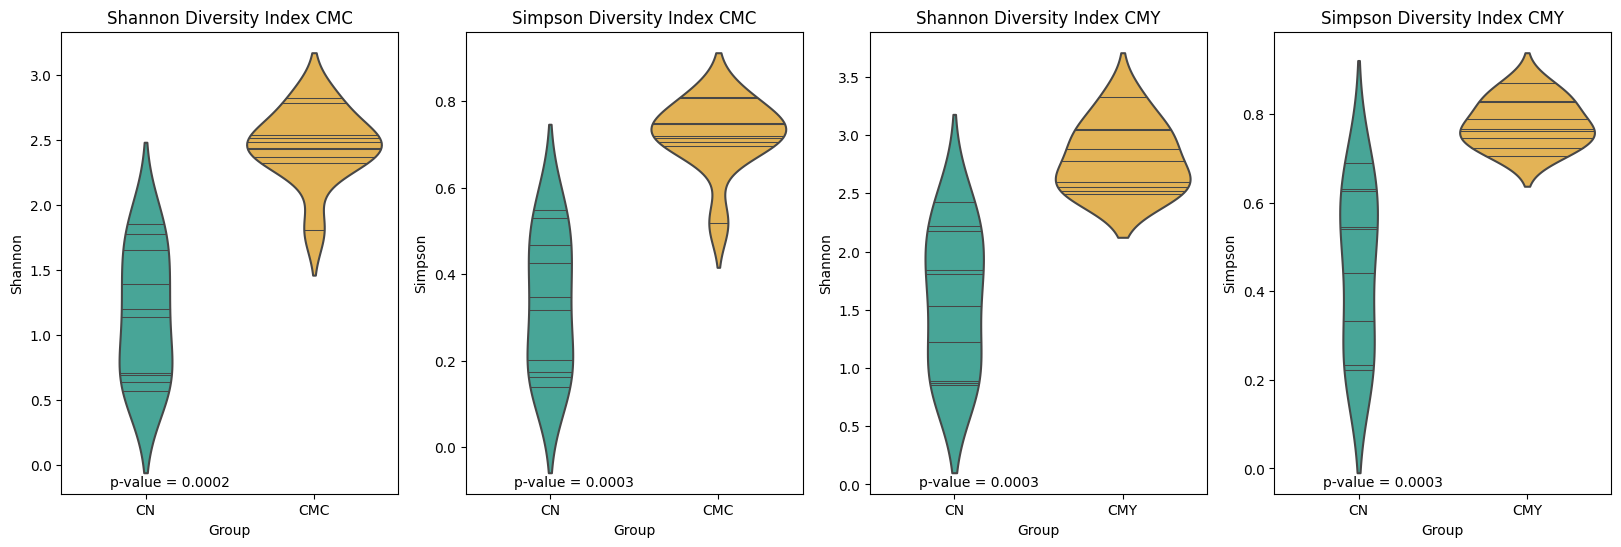

In [57]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))

def alpha_vizualization(df_cmc, df_cmy):
    my_palette = {'CN': '#39b4a2', 'CMC': '#faba3f', 'CMY': '#faba3f'} 
    for i in range(4):
        plt.subplot(1, 4, i+1)
        metric = "Shannon" if i % 2==0 else "Simpson"
        df = df_cmc if i < 2 else df_cmy
        sns.violinplot(x="Group", y=metric, data=df, inner="stick", palette=my_palette, order = ["CN", "CMC" if i < 2 else "CMY"])
        plt.title(f"{'Shannon' if i % 2 == 0 else 'Simpson'} Diversity Index {'CMC' if i < 2 else 'CMY'}")
        groups = df["Group"].unique()
        group1 = df[df["Group"] == groups[0]][metric]
        group2 = df[df["Group"] == groups[1]][metric]
        _, p_value = mannwhitneyu(group1, group2)
        
        plt.title(f"{metric} Diversity Index {'CMC' if i < 2 else 'CMY'}")
        
        # Добавление p-значения внутри графика
        plt.text(0.5, 0.01, f'p-value = {p_value:.4f}', horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes)

    plt.savefig('figures/alpha_diversity/alpha_violin_g.pdf', bbox_inches = 'tight')
    plt.show()

alpha_vizualization(alpha_cmc_g, alpha_cmy_g)



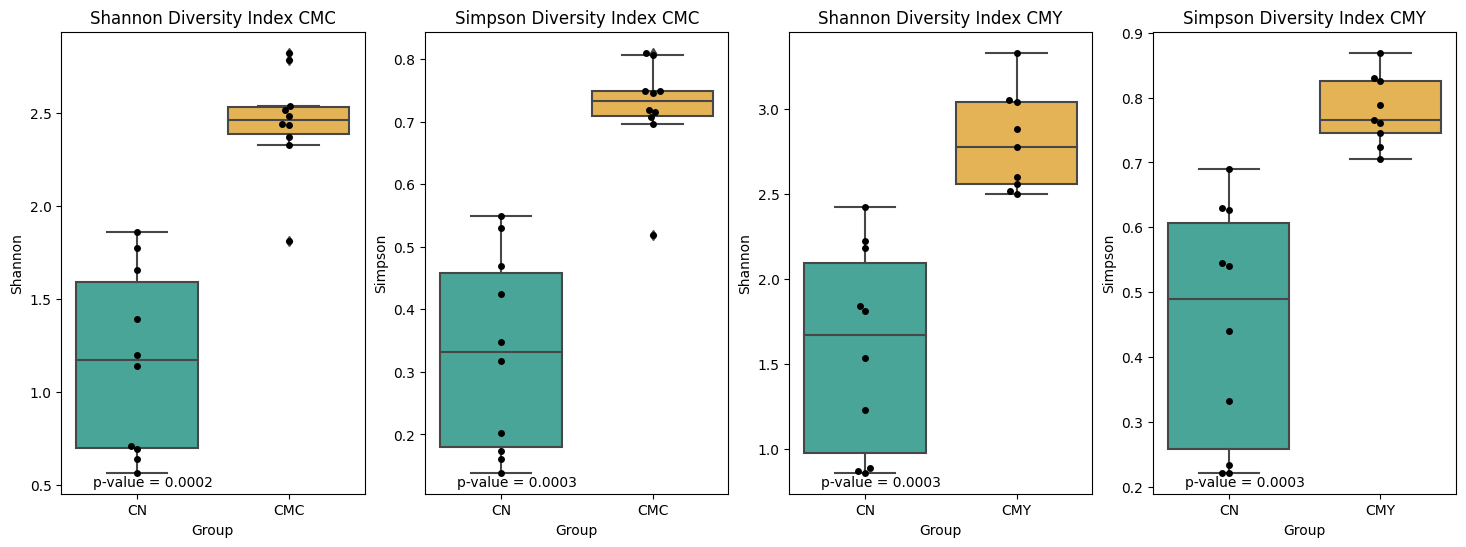

In [58]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 6))

def alpha_vizualization(df_cmc, df_cmy):
    for i in range(4):
        my_palette = {'CN': '#39b4a2', 'CMC': '#faba3f', 'CMY': '#faba3f'} 
        plt.subplot(1, 4, i+1)
        metric = "Shannon" if i % 2==0 else "Simpson"
        df = df_cmc if i < 2 else df_cmy
        
        sns.boxplot(x="Group", y=metric, data=df, order = ["CN", "CMC" if i < 2 else "CMY"], palette=my_palette)
        sns.swarmplot(x="Group", y=metric, data=df, color='black', order = ["CN", "CMC" if i < 2 else "CMY"])
        
        groups = df["Group"].unique()
        group1 = df[df["Group"] == groups[0]][metric]
        group2 = df[df["Group"] == groups[1]][metric]
        _, p_value = mannwhitneyu(group1, group2)
        
        plt.title(f"{metric} Diversity Index {'CMC' if i < 2 else 'CMY'}")
        
        # Добавление p-значения внутри графика
        plt.text(0.5, 0.01 if i > 1 else 0.01, f'p-value = {p_value:.4f}', horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes)

    plt.savefig('figures/alpha_diversity/alpha_boxplot_g.pdf', bbox_inches = 'tight')
    plt.show()

alpha_vizualization(alpha_cmc_g, alpha_cmy_g)


In [59]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import numpy as np

# Извлечение числовых данных
df_beta_cmc = merged_deleted_cmc_rel_dropped.copy()
df_beta_cmy = merged_deleted_cmy_rel_dropped.copy()


def rarify(matrix, count):
    rarified_matrix = []
    for row in matrix:
        if row.sum() > count:
            probs = row / row.sum()
            rarified_row = np.random.multinomial(count, probs)
            rarified_matrix.append(rarified_row)
        else:
            rarified_matrix.append(row)
    return np.array(rarified_matrix)



def hellinger_transformation(matrix):
    # Применение квадратного корня к каждому элементу
    transformed_matrix = np.sqrt(matrix)
    # Нормализация строк
    normalized_matrix = normalize(transformed_matrix, norm='l1', axis=1)
    return normalized_matrix


def beta_preparing(df_beta, hellinger=False, rarify_count=False):
    data_matrix = df_beta.drop(columns='Group').values
    
    # Применение преобразования Хеллингера
    if hellinger:
        data_matrix = hellinger_transformation(data_matrix)
    
    # Применение редкификации, если указано
    if rarify_count:
        data_matrix = rarify(data_matrix, rarify_count)

    # Расчет Bray-Curtis dissimilarity
    return pairwise_distances(data_matrix, metric='braycurtis')


bray_curtis_distances_cmc = beta_preparing(df_beta_cmc, False, False)
bray_curtis_distances_cmy = beta_preparing(df_beta_cmy, False, False)



/home/esp/python csv/Samat/rats27.07/vrats27.07/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.04132213015497397 and the largest is 0.9596992475966065.
  warn(


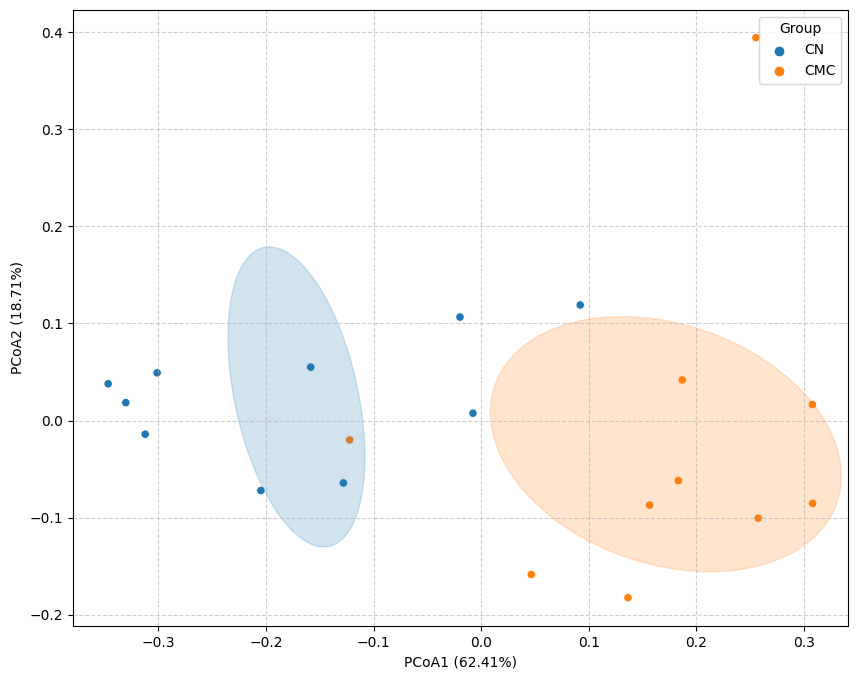

/home/esp/python csv/Samat/rats27.07/vrats27.07/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.022174336077570998 and the largest is 1.00544814292096.
  warn(


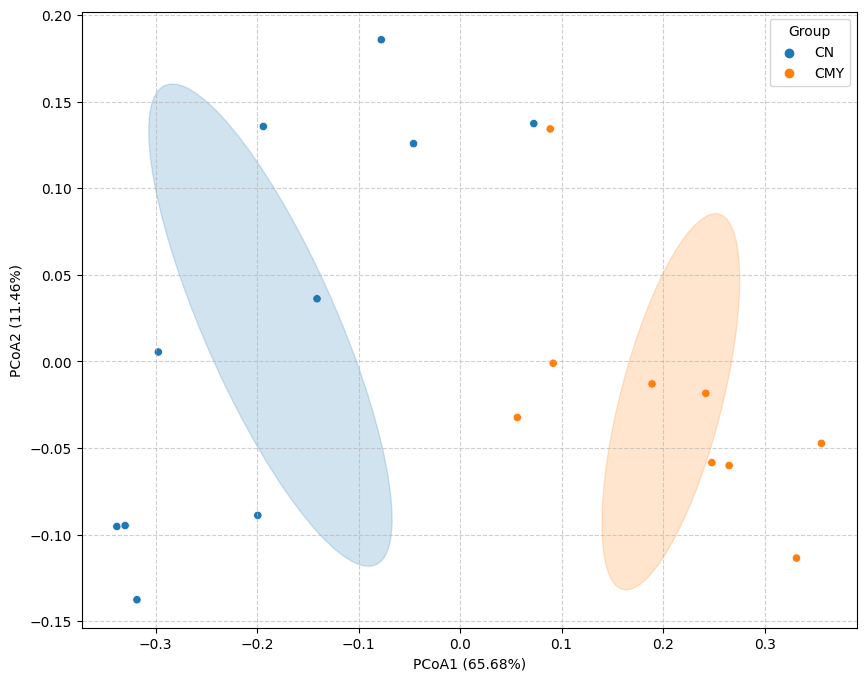

In [60]:
from skbio.stats.ordination import pcoa
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Преобразование расстояний Bray-Curtis в объект пакета skbio
from skbio import DistanceMatrix

def beta_vizualiztion(bray_curtis_df, firstable_data, group1 = "CMC"):
 
    dm = DistanceMatrix(bray_curtis_df)
    # Выполнение PCoA
    pcoa_results = pcoa(dm)
    # Собрать результаты в DataFrame
    pcoa_df = pd.DataFrame(data=pcoa_results.samples.values)
    pcoa_df['Group'] = firstable_data['Group'].values
    # Вычисление explained_variance_ratio
    explained_variance_ratio = pcoa_results.proportion_explained
    # Построение графика
    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(data=pcoa_df, x=0, y=1, hue='Group') # Измените 0 и 1 на названия столбцов, если у вас есть названия
    # Добавление эллипсов
    for group, values in pcoa_df.groupby('Group'):
        cov = values[[0, 1]].cov().values # Измените 0 и 1 на названия столбцов, если у вас есть названия
        mean = values[[0, 1]].mean().values # Измените 0 и 1 на названия столбцов, если у вас есть названия
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvectors = eigenvectors[:, order]
        vx, vy = eigenvectors[:, 0]
        theta = np.arctan2(vy, vx)
        color = sns.color_palette()[list(pcoa_df['Group'].unique()).index(group)]
        ellipse = mpatches.Ellipse(xy=mean, width=np.sqrt(eigenvalues[0]) * 2, height=np.sqrt(eigenvalues[1]) * 2, angle=np.degrees(theta), color=color, alpha=0.2,)
        plt.gca().add_artist(ellipse)

    ax.set_xlabel(f"PCoA1 ({explained_variance_ratio[0]*100:.2f}%)")
    ax.set_ylabel(f"PCoA2 ({explained_variance_ratio[1]*100:.2f}%)")

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f'figures/beta_diversity/bray_curtis_{group1}_g.pdf', bbox_inches = 'tight')
    plt.show()

beta_vizualiztion(bray_curtis_distances_cmc, df_beta_cmc, 'CMC')
beta_vizualiztion(bray_curtis_distances_cmy, df_beta_cmy, 'CMY')

In [61]:
from skbio import DistanceMatrix
from skbio.stats.distance import anosim, permanova

def beta_stats(bray_curtis_df, firstable_data, group1='CMC'):
    # Преобразование массива в матрицу расстояний
    distance_matrix = DistanceMatrix(bray_curtis_df)

    # Группировка по переменной 'Group'
    grouping = firstable_data['Group'].values

    # Проведение PERMANOVA теста
    permanova_results = permanova(distance_matrix, grouping)
    anosim_results = anosim(distance_matrix, grouping)

    print(f'\n\nCN vs {group1} stats PERMANOVA test result:\n {permanova_results}')
    print(f'\n\nCN vs {group1} stats ANOSIM test result:\n {anosim_results}')

beta_stats(bray_curtis_distances_cmc, df_beta_cmc)
beta_stats(bray_curtis_distances_cmy, df_beta_cmy, 'CMY')



CN vs CMC stats PERMANOVA test result:
 method name               PERMANOVA
test statistic name        pseudo-F
sample size                      20
number of groups                  2
test statistic            13.164889
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


CN vs CMC stats ANOSIM test result:
 method name                 ANOSIM
test statistic name              R
sample size                     20
number of groups                 2
test statistic            0.562889
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object


CN vs CMY stats PERMANOVA test result:
 method name               PERMANOVA
test statistic name        pseudo-F
sample size                      19
number of groups                  2
test statistic            17.657702
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


CN vs CMY st